# TimeSliderChoropleth

In this example we'll make a choropleth with a timeslider.

The class needs at least two arguments to be instantiated.

1. A string-serielized geojson containing all the features (i.e., the areas)
2. A dictionary with the following structure:


```ipython3
styledict = {
    '0': {
        '2017-1-1': {'color': 'ffffff', 'opacity': 1},
        '2017-1-2': {'color': 'fffff0', 'opacity': 1},
        ...
        },
    ...,
    'n': {
        '2017-1-1': {'color': 'ffffff', 'opacity': 1},
        '2017-1-2': {'color': 'fffff0', 'opacity': 1},
        ...
        }
}
```

In the above dictionary, the keys are the feature-ids.

Using both color and opacity gives us the ability to simultaneously visualize two features on the choropleth. I typically use color to visualize the main feature (like, average height) and opacity to visualize how many measurements were in that group.

## Loading the features

We use `geopandas` to load a dataset containing the boundaries of all the countries in the world.

In [1]:
import geodatasets
import geopandas

datapath = geodatasets.get_path("naturalearth land")
gdf = geopandas.read_file(datapath)

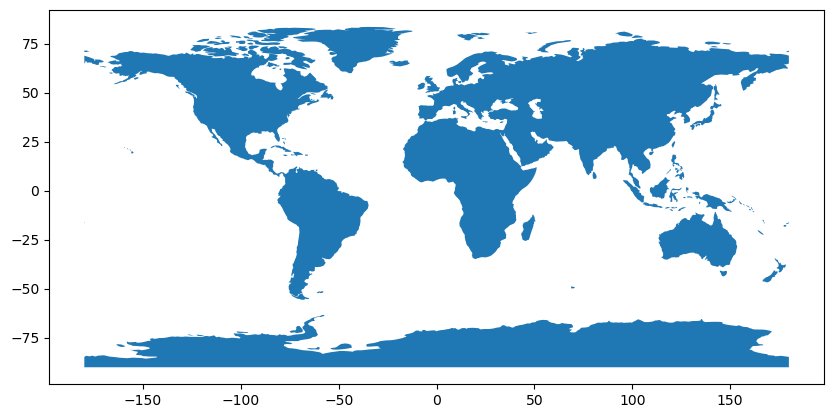

In [2]:
%matplotlib inline

ax = gdf.plot(figsize=(10, 10))

The `GeoDataFrame` contains the boundary coordinates, as well as some other data such as estimated population.

In [3]:
gdf.head()

,featurecla,scalerank,min_zoom,geometry
0,Land,1,1.0,"POLYGON ((-59.57209 -80.04018, -59.86585 -80.5..."
1,Land,1,1.0,"POLYGON ((-159.20818 -79.49706, -161.12760 -79..."
2,Land,1,0.0,"POLYGON ((-45.15476 -78.04707, -43.92083 -78.4..."
3,Land,1,1.0,"POLYGON ((-121.21151 -73.50099, -119.91885 -73..."
4,Land,1,1.0,"POLYGON ((-125.55957 -73.48135, -124.03188 -73..."


## Creating the style dictionary

Now we generate time series data for each country.

Data for different areas might be sampled at different times, and `TimeSliderChoropleth` can deal with that. This means that there is no need to resample the data, as long as the number of datapoints isn't too large for the browser to deal with.

To simulate that data is sampled at different times we random sample data for `n_periods` rows of data and then pick without replacing `n_sample` of those rows.

In [4]:
import pandas as pd

n_periods, n_sample = 48, 40

assert n_sample < n_periods

datetime_index = pd.date_range("2016-1-1", periods=n_periods, freq="ME")
dt_index_epochs = datetime_index.astype("int64") // 10 ** 9
dt_index = dt_index_epochs.astype("U10")

dt_index

Index(['1454198400', '1456704000', '1459382400', '1461974400', '1464652800',
       '1467244800', '1469923200', '1472601600', '1475193600', '1477872000',
       '1480464000', '1483142400', '1485820800', '1488240000', '1490918400',
       '1493510400', '1496188800', '1498780800', '1501459200', '1504137600',
       '1506729600', '1509408000', '1512000000', '1514678400', '1517356800',
       '1519776000', '1522454400', '1525046400', '1527724800', '1530316800',
       '1532995200', '1535673600', '1538265600', '1540944000', '1543536000',
       '1546214400', '1548892800', '1551312000', '1553990400', '1556582400',
       '1559260800', '1561852800', '1564531200', '1567209600', '1569801600',
       '1572480000', '1575072000', '1577750400'],
      dtype='object')

In [5]:
import numpy as np

styledata = {}

for country in gdf.index:
    df = pd.DataFrame(
        {
            "color": np.random.normal(size=n_periods),
            "opacity": np.random.normal(size=n_periods),
        },
        index=dt_index,
    )
    df = df.cumsum()
    df.sample(n_sample, replace=False).sort_index()
    styledata[country] = df

Note that the geodata and random sampled data is linked through the feature_id, which is the index of the `GeoDataFrame`.

In [6]:
gdf.loc[0]

featurecla                                                 Land
scalerank                                                     1
min_zoom                                                    1.0
geometry      POLYGON ((-59.57209469261153 -80.0401787250963...
Name: 0, dtype: object

In [7]:
styledata.get(0).head()

,color,opacity
1454198400,-1.348742,0.336733
1456704000,-2.515735,1.186135
1459382400,-2.573319,0.808666
1461974400,-1.951805,-0.535986
1464652800,-2.076102,-0.610895


We see that we generated two series of data for each country; one for color and one for opacity. Let's plot them to see what they look like.

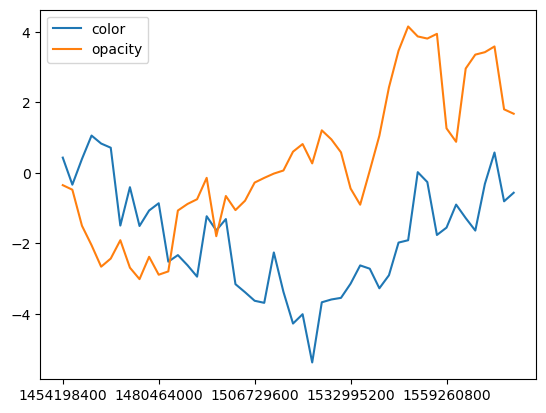

In [8]:
ax = df.plot()

Looks random alright. We want to map the column named `color` to a hex color. To do this we use a normal colormap. To create the colormap, we calculate the maximum and minimum values over all the timeseries. We also need the max/min of the `opacity` column, so that we can map that column into a range [0,1].

In [9]:
max_color, min_color, max_opacity, min_opacity = 0, 0, 0, 0

for country, data in styledata.items():
    max_color = max(max_color, data["color"].max())
    min_color = min(max_color, data["color"].min())
    max_opacity = max(max_color, data["opacity"].max())
    max_opacity = min(max_color, data["opacity"].max())

Define and apply colormaps:

In [10]:
from branca.colormap import linear

cmap = linear.PuRd_09.scale(min_color, max_color)


def norm(x):
    return (x - x.min()) / (x.max() - x.min())


for country, data in styledata.items():
    data["color"] = data["color"].apply(cmap)
    data["opacity"] = norm(data["opacity"])

In [11]:
styledata.get(0).head()

,color,opacity
1454198400,#decee5ff,0.439176
1456704000,#e6dfeeff,0.562630
1459382400,#e7e0efff,0.507768
1461974400,#e2d7eaff,0.312333
1464652800,#e3d8ebff,0.301446


Finally we use `pd.DataFrame.to_dict()` to convert each dataframe into a dictionary, and place each of these in a map from country id to data.

In [12]:
styledict = {
    str(country): data.to_dict(orient="index") for country, data in styledata.items()
}

## Creating the map

In [13]:
import folium
from folium.plugins import TimeSliderChoropleth


m = folium.Map([0, 0], zoom_start=2)

TimeSliderChoropleth(
    gdf.to_json(),
    styledict=styledict,
).add_to(m)

m

### Initial timestamp

By default the timeslider starts at the beginning. You can also select another timestamp to begin with using the `init_timestamp` parameter. Note that it expects an index to the list of timestamps. In this example we use `-1` to select the last timestamp.

In [14]:
m = folium.Map([0, 0], zoom_start=2)

TimeSliderChoropleth(
    gdf.to_json(),
    styledict=styledict,
    init_timestamp=-1,
).add_to(m)

m